# Import Liabraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download
from sklearn.datasets import fetch_20newsgroups
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from spacy import load
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

download('punkt')
download('stopwords')
download('omw-1.4')
download('wordnet')
nltk.download('wordnet2022')
nlp = load('en_core_web_sm')

! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


# Import Dataset

In [2]:
dataset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)

In [3]:
df = pd.DataFrame()

In [4]:
df['text'] = dataset.data

In [5]:
df['encoded_labels'] = dataset.target

In [6]:
label=[]
for i in df['encoded_labels']:
    label.append(dataset.target_names[i])
df['label']=label

In [7]:
df.head()

,text,encoded_labels,label
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,\nDo you have Weitek's address/phone number? ...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space


In [8]:
df.drop(['encoded_labels'],axis=1,inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11314 non-null  object
 1   label   11314 non-null  object
dtypes: object(2)
memory usage: 176.9+ KB


# Combine Subcategories of Labels

In [10]:
df['label'].value_counts()

label
rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
rec.autos                   594
sci.med                     594
comp.windows.x              593
sci.space                   593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: count, dtype: int64

In [11]:
df['label'].replace({'talk.politics.misc':'politics','talk.politics.guns':'politics','talk.politics.mideast':'politics'},inplace=True)                    
df['label'].replace({'rec.sport.hockey':'sport','rec.sport.baseball':'sport'},inplace=True)
df['label'].replace({'soc.religion.christian':'religion','talk.religion.misc':'religion', 'alt.atheism':'religion'},inplace=True)
df['label'].replace({'comp.windows.x':'computer','comp.sys.ibm.pc.hardware':'computer','comp.os.ms-windows.misc':'computer','comp.graphics':'computer','comp.sys.mac.hardware':'computer'},inplace=True)  
df['label'].replace({'misc.forsale':'sales'},inplace=True)
df['label'].replace({'rec.autos':'automobile','rec.motorcycles':'automobile'},inplace=True)
df['label'].replace({'sci.crypt':'science','sci.electronics':'science','sci.space':'science'},inplace=True)
df['label'].replace({'sci.med':'medicine'},inplace=True)

In [12]:
df.label.value_counts()

label
computer      2936
science       1779
politics      1575
religion      1456
sport         1197
automobile    1192
medicine       594
sales          585
Name: count, dtype: int64

# Data Cleaning

In [13]:
for i in range(0,10):
    print(df['text'][i])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. T

In [14]:
df['Number_of_words'] = df['text'].apply(lambda x:len(str(x).split()))
df['Number_of_words'].describe()

count    11314.000000
mean       185.827382
std        523.971647
min          0.000000
25%         40.000000
50%         83.000000
75%        167.000000
max      11765.000000
Name: Number_of_words, dtype: float64

In [15]:
no_text = df[df['Number_of_words']==0]
print(len(no_text))

df.drop(no_text.index,inplace=True)

300


In [16]:
def clean_text(text):
    text = text.lower()
    text = re.sub('[\d\W_]+', ' ', text)
    return text

df['text'] = df['text'].apply(lambda x: clean_text(x))

df['text'].head()

0    i was wondering if anyone out there could enli...
1    a fair number of brave souls who upgraded thei...
2    well folks my mac plus finally gave up the gho...
3     do you have weitek s address phone number i d...
4    from article c owcb n p world std com by tomba...
Name: text, dtype: object

In [17]:
df['text'] = df['text'].apply(nltk.word_tokenize)

df['text'].head()

0    [i, was, wondering, if, anyone, out, there, co...
1    [a, fair, number, of, brave, souls, who, upgra...
2    [well, folks, my, mac, plus, finally, gave, up...
3    [do, you, have, weitek, s, address, phone, num...
4    [from, article, c, owcb, n, p, world, std, com...
Name: text, dtype: object

In [18]:
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]
df['text'] = df['text'].apply(remove_stopwords)

In [19]:
df['text']

0        [wondering, anyone, could, enlighten, car, saw...
1        [fair, number, brave, souls, upgraded, si, clo...
2        [well, folks, mac, plus, finally, gave, ghost,...
3        [weitek, address, phone, number, like, get, in...
4        [article, c, owcb, n, p, world, std, com, tomb...
                               ...                        
11309    [dn, nyeda, cnsvax, uwec, edu, david, nye, dn,...
11310    [old, mac, k, mac, plus, problem, screens, bla...
11311    [installed, dx, cpu, clone, motherboard, tried...
11312    [require, hyper, sphere, space, points, specif...
11313    [stolen, pasadena, pm, blue, white, honda, cbr...
Name: text, Length: 11014, dtype: object

In [20]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]
df['text'] = df['text'].apply(lemmatize_tokens)

df['text']

0        [wondering, anyone, could, enlighten, car, saw...
1        [fair, number, brave, soul, upgraded, si, cloc...
2        [well, folk, mac, plus, finally, gave, ghost, ...
3        [weitek, address, phone, number, like, get, in...
4        [article, c, owcb, n, p, world, std, com, tomb...
                               ...                        
11309    [dn, nyeda, cnsvax, uwec, edu, david, nye, dn,...
11310    [old, mac, k, mac, plus, problem, screen, blan...
11311    [installed, dx, cpu, clone, motherboard, tried...
11312    [require, hyper, sphere, space, point, specifi...
11313    [stolen, pasadena, pm, blue, white, honda, cbr...
Name: text, Length: 11014, dtype: object

In [21]:
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

df['text'] = df['text'].apply(lambda x : combine_text(x))
df.head()

,text,label,Number_of_words
0,wondering anyone could enlighten car saw day d...,automobile,91
1,fair number brave soul upgraded si clock oscil...,computer,90
2,well folk mac plus finally gave ghost weekend ...,computer,307
3,weitek address phone number like get informati...,computer,15
4,article c owcb n p world std com tombaker worl...,science,72


In [22]:
df['Number_of_words'] = df['text'].apply(lambda x:len(str(x).split()))

In [23]:
df['Number_of_words'].describe()

count    11014.000000
mean       119.811694
std        559.505846
min          0.000000
25%         23.000000
50%         45.000000
75%         88.000000
max      14724.000000
Name: Number_of_words, dtype: float64

In [24]:
print(len(df[df['Number_of_words']==0]))

df.drop(df[df['Number_of_words']==0].index,inplace=True)

14


# Data Preprocessing

In [25]:
label_encoder = preprocessing.LabelEncoder()
df['target']= label_encoder.fit_transform(df['label'])

In [26]:
df

,text,label,Number_of_words,target
0,wondering anyone could enlighten car saw day d...,automobile,44,0
1,fair number brave soul upgraded si clock oscil...,computer,54,1
2,well folk mac plus finally gave ghost weekend ...,computer,147,1
3,weitek address phone number like get informati...,computer,8,1
4,article c owcb n p world std com tombaker worl...,science,46,6
...,...,...,...,...
11309,dn nyeda cnsvax uwec edu david nye dn neurolog...,medicine,165,2
11310,old mac k mac plus problem screen blank someti...,computer,58,1
11311,installed dx cpu clone motherboard tried mount...,computer,50,1
11312,require hyper sphere space point specifies sph...,computer,25,1


In [27]:
X = df['text']
y = df['target']

In [28]:
X

0        wondering anyone could enlighten car saw day d...
1        fair number brave soul upgraded si clock oscil...
2        well folk mac plus finally gave ghost weekend ...
3        weitek address phone number like get informati...
4        article c owcb n p world std com tombaker worl...
                               ...                        
11309    dn nyeda cnsvax uwec edu david nye dn neurolog...
11310    old mac k mac plus problem screen blank someti...
11311    installed dx cpu clone motherboard tried mount...
11312    require hyper sphere space point specifies sph...
11313    stolen pasadena pm blue white honda cbr rr cal...
Name: text, Length: 11000, dtype: object

In [29]:
y

0        0
1        1
2        1
3        1
4        6
        ..
11309    2
11310    1
11311    1
11312    1
11313    0
Name: target, Length: 11000, dtype: int64

### Encoding Text using Universal Sentence Encoder

In [30]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") 

In [31]:
def embed_sentences(text):
    return embed([text])[0]

In [32]:
X = X.apply(embed_sentences)

In [33]:
X

0        (tf.Tensor(-0.071507685, shape=(), dtype=float...
1        (tf.Tensor(-0.051847, shape=(), dtype=float32)...
2        (tf.Tensor(-0.05817831, shape=(), dtype=float3...
3        (tf.Tensor(0.06725894, shape=(), dtype=float32...
4        (tf.Tensor(-0.021581052, shape=(), dtype=float...
                               ...                        
11309    (tf.Tensor(-0.056577653, shape=(), dtype=float...
11310    (tf.Tensor(-0.054178465, shape=(), dtype=float...
11311    (tf.Tensor(-0.051046394, shape=(), dtype=float...
11312    (tf.Tensor(0.0063113985, shape=(), dtype=float...
11313    (tf.Tensor(-0.047903147, shape=(), dtype=float...
Name: text, Length: 11000, dtype: object

In [34]:
def convert_to_numpy(tensor):
    numpy_array = tensor.numpy()
    return numpy_array

In [35]:
X = X.apply(convert_to_numpy)

In [36]:
X

0        [-0.071507685, -0.0015432752, -0.062018566, 0....
1        [-0.051847, -0.06404878, -0.05822647, -0.00226...
2        [-0.05817831, -0.06813692, -0.059906334, -0.00...
3        [0.06725894, -0.024005428, -0.028593937, -0.01...
4        [-0.021581052, -0.026666228, -0.06559357, 0.00...
                               ...                        
11309    [-0.056577653, -0.056718677, 0.050330747, 0.04...
11310    [-0.054178465, -0.020059245, -0.04904539, 0.03...
11311    [-0.051046394, -0.0008216206, -0.043964643, 0....
11312    [0.0063113985, -0.034197673, -0.03608448, -0.0...
11313    [-0.047903147, -0.03546843, -0.04807608, 0.054...
Name: text, Length: 11000, dtype: object

In [37]:
X = np.array(X.tolist())

In [38]:
X

array([[-0.07150768, -0.00154328, -0.06201857, ..., -0.01289622,
        -0.05056163,  0.0176503 ],
       [-0.051847  , -0.06404878, -0.05822647, ..., -0.0520738 ,
        -0.04848232,  0.01182713],
       [-0.05817831, -0.06813692, -0.05990633, ...,  0.0375379 ,
        -0.06538071,  0.00691786],
       ...,
       [-0.05104639, -0.00082162, -0.04396464, ...,  0.01615767,
         0.02913973, -0.04816674],
       [ 0.0063114 , -0.03419767, -0.03608448, ...,  0.04501105,
         0.02705993, -0.01341113],
       [-0.04790315, -0.03546843, -0.04807608, ..., -0.02043457,
        -0.00825753, -0.04392315]], dtype=float32)

### Converting Imbalanced Dataset into Balanced using SMOTE Technique

In [39]:
smote = SMOTE(random_state = 42)
X_smote, Y_smote = smote.fit_resample(X,y)

In [40]:
Y_smote.value_counts()

target
0    2860
1    2860
6    2860
3    2860
2    2860
4    2860
5    2860
7    2860
Name: count, dtype: int64

# Train Test Split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, Y_smote, test_size = 0.20, random_state = 42)
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((18304, 512), (4576, 512), (18304,), (4576,))

In [42]:
X_train

array([[-0.04885447, -0.05235079, -0.00521959, ...,  0.05135054,
        -0.05211136, -0.02379916],
       [-0.01664642, -0.00181315, -0.06052542, ...,  0.01265132,
         0.05008691, -0.03299011],
       [ 0.0162856 , -0.04943101, -0.03873874, ...,  0.00532466,
        -0.06306638, -0.03651597],
       ...,
       [ 0.04315497, -0.06483505, -0.059738  , ...,  0.01344217,
        -0.0258328 , -0.01994891],
       [-0.04582132,  0.04001233, -0.00747306, ..., -0.05663812,
        -0.05620847, -0.04200163],
       [-0.00760439, -0.04088121, -0.06287394, ...,  0.03821588,
        -0.04905653, -0.00290441]], dtype=float32)

# Creating Neural Network of Bidirectional LSTM for Training Model

In [43]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(Bidirectional(LSTM(512)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/30
572/572 [==============================] - 9s 6ms/step - loss: 0.5911 - accuracy: 0.8211 - val_loss: 0.3879 - val_accuracy: 0.8693
Epoch 2/30
572/572 [==============================] - 3s 5ms/step - loss: 0.3711 - accuracy: 0.8792 - val_loss: 0.3547 - val_accuracy: 0.8816
Epoch 3/30
572/572 [==============================] - 3s 5ms/step - loss: 0.3292 - accuracy: 0.8914 - val_loss: 0.3377 - val_accuracy: 0.8894
Epoch 4/30
572/572 [==============================] - 3s 5ms/step - loss: 0.2981 - accuracy: 0.9024 - val_loss: 0.3324 - val_accuracy: 0.8868
Epoch 5/30
572/572 [==============================] - 3s 5ms/step - loss: 0.2676 - accuracy: 0.9122 - val_loss: 0.3330 - val_accuracy: 0.8855
Epoch 6/30
572/572 [==============================] - 3s 5ms/step - loss: 0.2395 - accuracy: 0.9214 - val_loss: 0.3173 - val_accuracy: 0.8988
Epoch 7/30
572/572 [==============================] - 3s 5ms/step - loss: 0.2148 - accuracy: 0.9282 - val_loss: 0.2910 - val_accuracy: 0.9069
Epoch 

### Model obtained accuracy of 93.44% on Test Dataset

# Visualization of Accuracy, Loss and Confusion Matrix

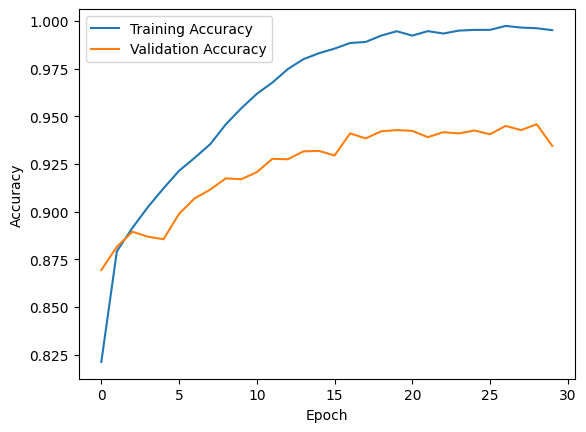

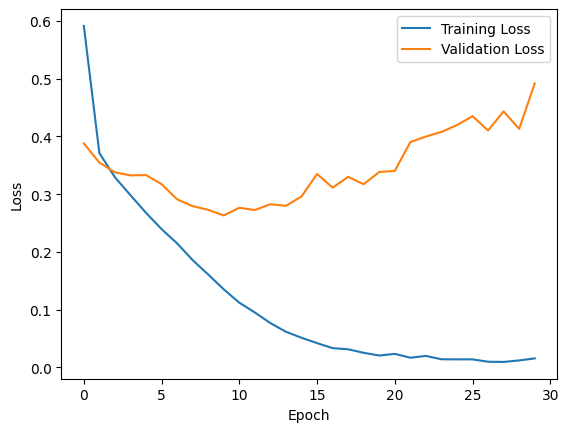

In [44]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

143/143 [==============================] - 1s 2ms/step


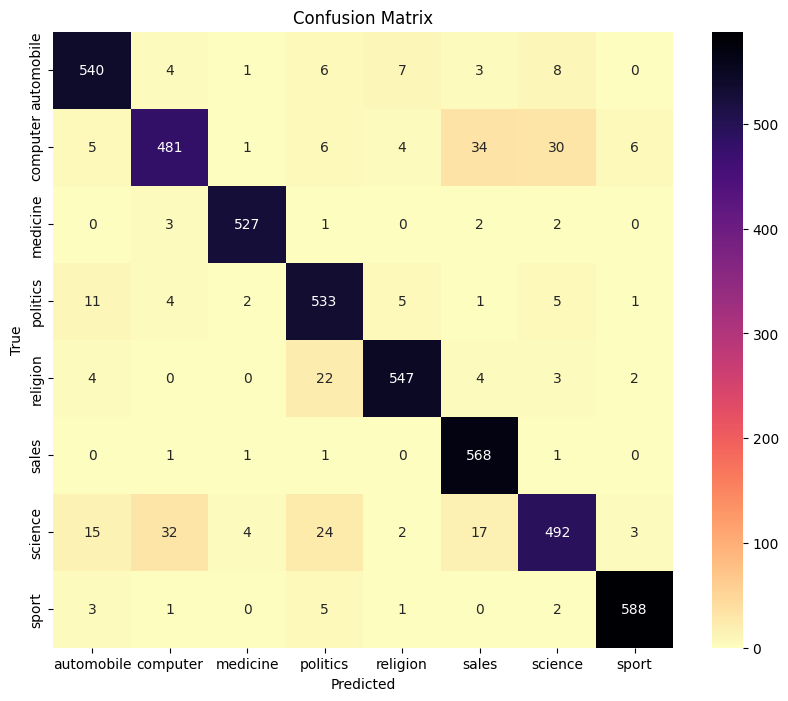

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_test_classes = np.argmax(tf.keras.utils.to_categorical(y_test, num_classes=13), axis=1)

conf_mat = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='magma_r', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Saving Model and Labels in H5 and joblib format respectively

In [46]:
model.save('model.h5')

import joblib
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']